# Objective

In this notebook we are showcasing a model that can predict the review given to an anime by the general public.

After that we are going to fine tune the model on a specific user to try and learn its preferences.

In [164]:
import torch as t

device = "cuda" if t.cuda.is_available() else "cpu"
print(f"using device: {device}")

using device: cuda


# Dataset

After preprocessing (done with knime) we now have a csv file containing the data

The result is a dataset that has splits data like so: User, Anime Information, Rating

In [165]:
from pandas import read_csv
from torch.utils.data import Dataset

class AnimeReviewsDataset(Dataset):
    def __init__(self, path) -> None:
        df = read_csv(path)
        self.ratings = df["rating"].to_list()
        self.users = df["user_id"].to_list()
        df = df.drop(columns=["rating", "user_id"])
        # TODO add genre support
        df = df.drop(columns=["Genres"]) # Not handling genres for now

        self.anime_features = df

    def __len__(self):
        return len(self.users)
    
    def __getitem__(self, index):
        user = t.Tensor([self.users[index]])
        anime_features = t.Tensor(self.anime_features.iloc[[index]].to_numpy().tolist())
        rating = t.Tensor([self.ratings[index]])

        return user, anime_features, rating


dataset = AnimeReviewsDataset("/home/andreacacioli/Documents/github/MachineLearning/Anime Recommender System (Knime)/preprocessed_anime_reviews_short.csv")
print(dataset.__getitem__(120))
print(dataset.anime_features.iloc[[120]])
print("Values of type:")
print(dataset.anime_features["Type"].unique())
types = len(dataset.anime_features["Type"].unique())
print(f"types = {types}")

(tensor([277341.]), tensor([[  8.5100,   1.0000,   1.0000,  14.0000, 102.0000, 195.0000]]), tensor([7.]))
     Score  Type  Episodes  Studios  Ranked  Popularity
120   8.51     1         1       14     102         195
Values of type:
[0 1 2 3 4 5]
types = 6


# Separate the dataset

We split the dataset into training, test and validation

In [166]:
from torch.utils.data import random_split, DataLoader
batch_size = 512

train_dataset, test_dataset, validation_dataset = random_split(dataset, [0.7, 0.2, 0.1])

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
validation_dataloader = DataLoader(validation_dataset, shuffle=True, batch_size=batch_size)

# Define a generic step

We perform this step regardless of the model, optimizer, or the phase we are in (training / test)

In [167]:
def run_step(model, loss_fn, features, target) -> t.Tensor:
    features = features.squeeze().to(device)
    target = target.squeeze().long().to(device)
    ones = t.ones(target.shape).long().to(device)
    target = t.sub(target, ones) # To go from ratings in [1:10] to values in [0:9]
    x = model(features)
    loss = loss_fn(x, target)
    return loss

# The Model

Now it is time to build the model that predicts the value of a rating given the features

In [168]:
class MLP_Predictor(t.nn.Module):
    def __init__(self, types, emb_size, device, ratings = 10) -> None:
        super().__init__()
        self.device = device
        self.embed = t.nn.Embedding(types, emb_size).to(device)
        self.sequential = t.nn.Sequential(
            # We expect 5 features + the type
            t.nn.Linear(5 + emb_size, 1024),
            t.nn.ReLU(),
            t.nn.Dropout(0.2),
            t.nn.Linear(1024, 2048),
            t.nn.ReLU(),
            t.nn.Dropout(0.2),
            t.nn.Linear(2048, 2048),
            t.nn.ReLU(),
            t.nn.Linear(2048, 2048),
            t.nn.ReLU(),
            t.nn.Dropout(0.2),
            t.nn.Linear(2048, 2048),
            t.nn.ReLU(),
            t.nn.Dropout(0.2),
            t.nn.Linear(2048, 2048),
            t.nn.ReLU(),
            t.nn.Dropout(0.2),
            t.nn.Linear(2048, 2048),
            t.nn.ReLU(),
            t.nn.Dropout(0.2),
            t.nn.BatchNorm1d(2048),
            t.nn.Linear(2048, ratings)
            #t.nn.Softmax(dim=1) # To get a probability distribution (Not Necessary but good for the looks)
        ).to(device)


    def forward(self, x):
        B, L = x.shape
        x.to(self.device)
        assert L == 6, "This predictor expects a 6-element feature vector"

        # Get the type (position 1 in the feature vector)
        ty = x[:, 1:2].long().squeeze()
        # Remove the type from x
        x = t.cat([x[:, :1], x[:, 2:]], dim=1)
        #Embed the type
        ty = self.embed(ty)

        x = t.cat([x, ty], dim=1)
        x = self.sequential(x)
        return x

    def size(self):
        def human_format(num):
            magnitude = 0
            while abs(num) >= 1000:
                magnitude += 1
                num /= 1000.0
            # add more suffixes if you need them
            return '%.2f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])
        return human_format(sum(p.numel() for p in self.parameters()))


model = MLP_Predictor(types, 10, device)
print(model.size())

23.12M


# First Steps

Here we check if everything is set up correctly

In [169]:
loss_fn = t.nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = t.optim.Adam(model.parameters(), learning_rate)
_, features, target = next(iter(train_dataloader))
loss = run_step(model, loss_fn, features, target)
loss

tensor(2.4244, device='cuda:0', grad_fn=<NllLossBackward0>)

# Training Loop

We set up a simple training loot that uses the validation and training sets to train the model

In [ ]:
from tqdm import tqdm

train_losses = []
validation_losses = []
epochs = 200
for epoch in range(epochs):
    current_train_loss = []
    current_eval_loss = []
    for user, features, target in tqdm(train_dataloader):
        #Training Step
        optimizer.zero_grad()
        loss = run_step(model, loss_fn, features, target).mean()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        current_train_loss.append(loss.item())

        #Validation Step
        model.train(False)
        _, fe, ta = next(iter(validation_dataloader))
        loss = run_step(model, loss_fn, fe, ta).mean().item()
        validation_losses.append(loss)
        current_eval_loss.append(loss)
        model.train(True)
    
    print(f"Finished epoch {epoch + 1}")
    print(f"Training loss average = {sum(current_train_loss) / len(current_train_loss)}")
    print(f"Evaluation loss average = {sum(current_eval_loss) / len(current_eval_loss)}")


# Plotting the epoch

Using matplotlib to plot the result of the experiment

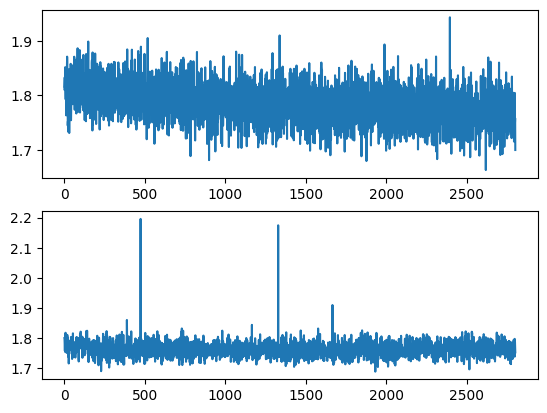

In [175]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2)

x = list(range(1, len(train_losses) + 1))
axs[0].plot(x, train_losses)


x = list(range(1, len(validation_losses) + 1))
# TODO use the median to remove outliers
axs[1].plot(x, validation_losses)
plt.show()